In [1]:
!pip install pycuda
!pip install py-cpuinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.4/92.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=fa57f591b989f95c6aea71a0c78854823572980f463cce03c283529f67ec3c41
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [13]:
import numpy as np
import numba
from numba import cuda
import math
from time import time
from PIL import Image
import matplotlib.pyplot as plt

In [44]:
# Добавление шума
def add_salt_and_pepper_noise(image, prob):
    rnd = np.random.rand(image.shape[0], image.shape[1])
    noisy = image.copy()
    noisy[rnd < prob] = 0
    noisy[rnd > 1 - prob] = 255
    return noisy

In [45]:
# Фильтр на CPU
def apply_median_filter_cpu(a):
    b = a.copy()
    start = time()
    for i in range(2, len(a) - 1):
        for j in range(2, len(a[i]) - 1):
            t = [0] * 9

            t[0] = a[i-1][j-1]
            t[1] = a[i-1][j]
            t[2] = a[i-1][j+1]
            t[3] = a[i][j-1]
            t[4] = a[i][j]
            t[5] = a[i][j+1]
            t[6] = a[i+1][j-1]
            t[7] = a[i+1][j]
            t[8] = a[i+1][j+1]

            for k in range(8):
                for l in range(8-k):
                    if t[l] > t[l+1]:
                        t[l], t[l+1] = t[l+1], t[l]
            b[i][j] = t[int(len(t)/2)]
    return b, time() - start

In [47]:
@cuda.jit
# Фильтр на GPU
def apply_median_filter_gpu(a, b):
    i, j = cuda.grid(2)
    t = cuda.local.array(shape=9, dtype=numba.int64)

    t[0] = a[i-1][j-1]
    t[1] = a[i-1][j]
    t[2] = a[i-1][j+1]
    t[3] = a[i][j-1]
    t[4] = a[i][j]
    t[5] = a[i][j+1]
    t[6] = a[i+1][j-1]
    t[7] = a[i+1][j]
    t[8] = a[i+1][j+1]

    for k in range(8):
        for l in range(8-k):
            if t[l] > t[l+1]:
                t[l], t[l+1] = t[l+1], t[l]
    b[i][j] = t[int(len(t)/2)]

In [48]:
# Подготовка и выполнение медианного фильтра на GPU
def prepare_and_execute_gpu(a):
    b = a.copy()
    thread_number_block = 32

    a_global = cuda.to_device(a)
    b_global = cuda.to_device(b)

    threadsperblock = (thread_number_block, thread_number_block)
    blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
    blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start = time()
    apply_median_filter_gpu[blockspergrid, threadsperblock](a_global, b_global)
    return b_global.copy_to_host(), time() - start

In [49]:
def test(name, salt):
    im = Image.open(name).convert('L')
    img_width, img_height = im.size  # Получение размеров изображения

    img_array = np.array(im)

    # Добавление шума
    img_array = add_salt_and_pepper_noise(img_array, 0.02)

    if salt:
        plt.figure(figsize=(16, 12))  # Увеличивание размера фигуры для 4 изображений

        # Исходное изображение
        plt.subplot(2, 2, 1)
        plt.imshow(im, cmap='gray')
        plt.title('Исходное изображение')
        plt.axis('off')

        # Шум
        plt.subplot(2, 2, 2)
        plt.imshow(img_array, cmap='gray')
        plt.title('Зашумленное')
        plt.axis('off')

        # Применение медианного фильтра CPU
        filtered_img_cpu, c_time = apply_median_filter_cpu(img_array)

        plt.subplot(2, 2, 3)
        plt.imshow(filtered_img_cpu, cmap='gray')
        plt.title('CPU')
        plt.axis('off')

        # Применение медианного фильтра GPU
        filtered_img_gpu, g_time = prepare_and_execute_gpu(img_array)

        plt.subplot(2, 2, 4)
        plt.imshow(filtered_img_gpu, cmap='gray')
        plt.title('GPU')
        plt.axis('off')

        # Отображение
        plt.tight_layout()
        plt.show()

        # Сохранение
        noisy_img = Image.fromarray(np.uint8(img_array))
        noisy_img.save('salt.jpg')

        cpu_img = Image.fromarray(np.uint8(filtered_img_cpu))
        cpu_img.save('cpu.jpg')

        gpu_img = Image.fromarray(np.uint8(filtered_img_gpu))
        gpu_img.save('gpu.jpg')

    n = img_width * img_height  # Количество пикселей
    total_elements = len(img_array) * len(img_array[0])
    print('Размеры изображения =', img_width, 'x', img_height)
    print('Время выполнения на CPU =', c_time)
    print('Время выполнения на GPU =', g_time)
    print('Ускорение =', c_time/g_time)
    print()

    return c_time/g_time, total_elements

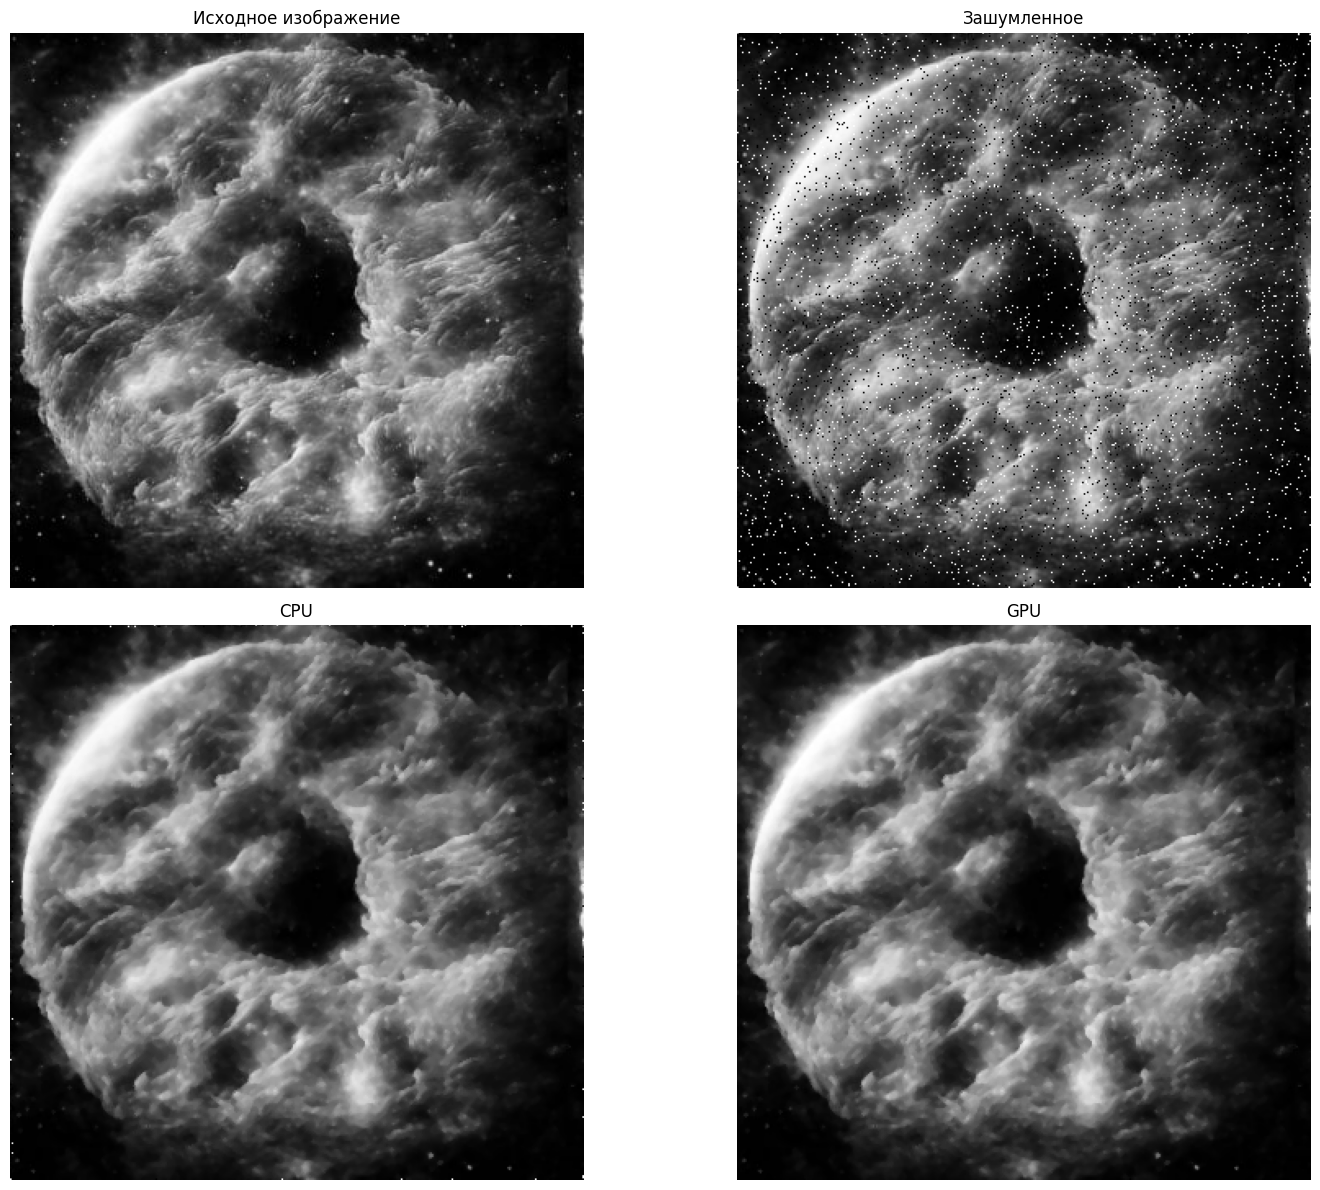

Размеры изображения = 351 x 340
Время выполнения на CPU = 1.1265103816986084
Время выполнения на GPU = 0.00034117698669433594
Ускорение = 3301.835779175402



In [51]:
IMG = '/content/photo_2024-12-24_05-37-02.jpg'
a1, n1 = test(IMG, True)